## **1. Create a DataModule**


In [50]:
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import mlstac
import glob
from torch.utils.data import Dataset
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

In [36]:
def normalize_band(band, stretch_factor=1.5):
  """
  Normalizes a band and stretches contrast.

  Args:
      band: A numpy array representing the band data.
      stretch_factor: A factor to control the amount of contrast stretching (default: 1.5).

  Returns:
      A numpy array with normalized and stretched band values.
  """
  return ((band - band.min()) / (band.max() - band.min()) * stretch_factor)

In [3]:
# Listar arquivos de treino, validação e teste
train_files = glob.glob('D:/CloudSEN12+/p509/high/train/*/*/*.tif')
val_files = glob.glob('D:/CloudSEN12+/p509/high/val/*/*/*.tif')
test_files = glob.glob('D:/CloudSEN12+/p509/high/test/*/*/*.tif')

# Criar DataFrames e adicionar a coluna 'set_type'
train_df = pd.DataFrame(train_files, columns=['file_path'])
train_df['set_type'] = 'train'

val_df = pd.DataFrame(val_files, columns=['file_path'])
val_df['set_type'] = 'val'

test_df = pd.DataFrame(test_files, columns=['file_path'])
test_df['set_type'] = 'test'

# Concatenar todos os DataFrames
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [66]:
src = rasterio.open(df[df['set_type'] == 'train']['file_path'][0])
# Ler todas as bandas
sample = src.read()
b_r = normalize_band(sample[3], stretch_factor=1)
b_g = normalize_band(sample[2], stretch_factor=1)
b_b = normalize_band(sample[1], stretch_factor=1)
rgb_composite_raw = (np.dstack((b_r, b_g, b_b))).clip(0,1)

In [67]:
teste = sample[0:13]

In [68]:
teste.max()

11147

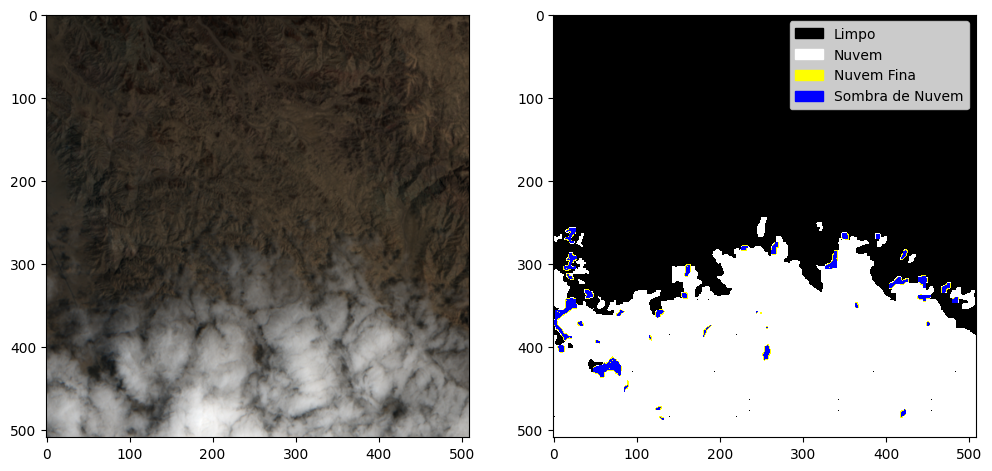

In [59]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(rgb_composite_raw)
plt.subplot(1,2,2)
cmap = mcolors.ListedColormap(['black', 'white', 'yellow', 'blue'])  # Defina as cores
bounds = [0, 1, 2, 3, 4]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
plt.imshow(sample[13], cmap=cmap, norm=norm)
# Criando a legenda manualmente
legend_labels = ['Limpo', 'Nuvem', 'Nuvem Fina', 'Sombra de Nuvem']
legend_colors = ['black', 'white', 'yellow', 'blue']

patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
plt.legend(handles=patches, loc='upper right')



In [ ]:
src = rasterio.open(df[df['set_type'] == 'train']['file_path'][0])
# Ler todas as bandas
sample = src.read()

plt.subplot(1,2,1)
# for visualization we have to transpose back to HWC
plt.imshow(sample[1:4].transpose(2, 1, 0))
plt.subplot(1,2,2)
# for visualization we have to remove 3rd dimension of mask
plt.imshow(sample['mask'].squeeze())
plt.show()

sample = val_dataset[0]
plt.subplot(1,2,1)
# for visualization we have to transpose back to HWC
plt.imshow(sample['image'].numpy().transpose(1, 2, 0))
plt.subplot(1,2,2)
# for visualization we have to remove 3rd dimension of mask
plt.imshow(sample['mask'].squeeze())
plt.show()

sample = test_dataset[1]
plt.subplot(1,2,1)
# for visualization we have to transpose back to HWC
plt.imshow(sample['image'].numpy().transpose(1, 2, 0))
plt.subplot(1,2,2)
# for visualization we have to remove 3rd dimension of mask
plt.imshow(sample['mask'].squeeze())
plt.show()

In [31]:
class CoreDataset(Dataset):
    def __init__(self, subset: pd.DataFrame):
        subset.reset_index(drop=True, inplace=True)
        self.subset = subset

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, index: int):
        # Obter o caminho do arquivo a partir do DataFrame
        img_path = self.subset.iloc[index]['file_path']
        
       
        src = rasterio.open(img_path)
        # Ler todas as bandas
        bandas = src.read()
        sample = np.array(bandas)



        # Assumindo que as bandas estão nos primeiros canais
        X = sample[0:13, 0:32, 0:32].astype(np.float32) / 10000
        
        # Assumindo que o alvo está no canal 14 (index 13)
        y = sample[13, 0:32, 0:32].astype(np.int64)
        
        return X, y


In [32]:
class CoreDataModule(pl.LightningDataModule):
    def __init__(self, dataframe: pd.DataFrame, batch_size: int = 4):
        super().__init__()
        
        # Separar o DataFrame em datasets de treino, validação e teste
        self.train_dataset = dataframe[dataframe['set_type'] == 'train']
        self.validation_dataset = dataframe[dataframe['set_type'] == 'val']
        self.test_dataset = dataframe[dataframe['set_type'] == 'test']
        
        # Definir o batch_size
        self.batch_size = batch_size

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset=CoreDataset(self.train_dataset),
            batch_size=self.batch_size,
            shuffle=True
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset=CoreDataset(self.validation_dataset),
            batch_size=self.batch_size
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset=CoreDataset(self.test_dataset),
            batch_size=self.batch_size
        )

## **2. Define a Model**

In [33]:
import segmentation_models_pytorch as smp
import torch

class litmodel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = smp.Unet(encoder_name="mobilenet_v2", encoder_weights=None, classes=4, in_channels=13)
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

## **3. Define the Trainer**

In [34]:
# Define the callbacks
callbacks = [
    pl.callbacks.ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=3
    ),
    pl.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        mode="min"
    )
]

# Define the trainer
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=callbacks,
    accelerator="auto",
    precision="16-mixed"
)

# Define the datamodule
datamodule = CoreDataModule(dataframe=df, batch_size=2)

# Define the model
model = litmodel()

# Start the training
trainer.fit(model=model, datamodule=datamodule)

c:\Users\alanb\anaconda3\envs\cloud\Lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:512: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | Unet             | 6.6 M  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.529    Total estimated model params size (MB)
285       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\alanb\anaconda3\envs\cloud\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


c:\Users\alanb\anaconda3\envs\cloud\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 0:  15%|█▍        | 616/4245 [16:57<1:39:54,  0.61it/s, v_num=1]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined